# Advanced Hyperparameter Tuning

You know what's frustrating? Training a model for 12 hours, coming back with coffee in hand, and seeing "Loss: NaN" on your screen.

(Ask me how I know.)

Hyperparameters matter. Like, *really* matter. The difference between a hyperparameter configuration that works and one that doesn't isn't subtle—it's the difference between "my model is learning!" and "why is everything on fire?"

This notebook is your guide to tuning hyperparameters for SFT, DPO, and RLHF. We'll explain what each knob does, why it matters, and how to avoid the common mistakes that make models sad.

## The Stakes: Why Hyperparameters Matter

Let's start with a reality check. What can happen with different hyperparameter choices:

**Bad hyperparameters:**
```
Step 100:  Loss = 2.5
Step 200:  Loss = 2.3  (okay, moving in the right direction...)
Step 300:  Loss = 2.4  (wait, it went up?)
Step 400:  Loss = 2.6  (this is bad)
Step 500:  Loss = NaN  (everything is on fire)
```

**Good hyperparameters:**
```
Step 100:  Loss = 2.5
Step 200:  Loss = 1.8  (nice!)
Step 300:  Loss = 1.4  (getting better)
Step 400:  Loss = 1.2  (smooth sailing)
Step 500:  Loss = 1.1  (we have a winner)
```

Same model. Same data. Different hyperparameters.

The good news? You don't need to guess randomly. There are patterns, heuristics, and rules of thumb that work across different models and tasks. That's what we're here to learn.

## Learning Rate: The King of Hyperparameters

If you only tune one hyperparameter, make it the learning rate.

**What is it?** The learning rate controls how big of a step your optimizer takes when updating model weights. Think of it like this: you're hiking down a mountain in the fog (the fog is the loss landscape, stay with me). The learning rate is how big your steps are.

- **Too high:** You take huge steps, overshoot the valley, and bounce around like a pinball. Eventually you might bounce right off the mountain (Loss = NaN).
- **Too low:** You take tiny, shuffling steps. You're *technically* making progress, but you'll die of old age before reaching the bottom.
- **Just right:** Nice, confident steps that make steady progress toward the minimum.

Here's the tricky part: the "right" learning rate depends on what you're doing.

### Learning Rates for SFT (Supervised Fine-Tuning)

When you're doing supervised fine-tuning, your model is already pre-trained. The weights are already pretty good! You just need to nudge them in the right direction. Small, gentle nudges.

| Setup | Learning Rate | Why? |
|-------|--------------|------|
| Full fine-tuning | 2e-5 to 5e-5 | Model already knows language, small updates preserve that knowledge |
| LoRA (r=8-16) | 1e-4 to 5e-4 | LoRA parameters start random, need stronger updates to learn anything |
| LoRA (r=32-64) | 5e-5 to 2e-4 | Higher capacity = more parameters = more stable training |

Notice something? LoRA uses a *higher* learning rate than full fine-tuning. This trips people up constantly. "Wait, I thought lower learning rates were safer?" They are! But LoRA's low-rank matrices start from random initialization. You need a bigger learning rate to get them moving.

### Learning Rates for DPO (Direct Preference Optimization)

DPO is... sensitive. Like, *really* sensitive. You're not teaching the model new tasks, you're adjusting its preferences between similar outputs. This requires a delicate touch.

| Setup | Learning Rate | Why? |
|-------|--------------|------|
| Full fine-tuning | 5e-6 to 2e-5 | Tiny changes to preferences, don't want to break the model |
| LoRA (r=8-16) | 5e-5 to 2e-4 | Random init again, need stronger signal |

Notice DPO's learning rates are roughly 5-10x lower than SFT for the same setup. That's because the preference signal is subtle—if you use a huge learning rate, you'll overfit to your preference data and make the model weird.

### Learning Rates for RLHF (Reinforcement Learning from Human Feedback)

RLHF with PPO is the most sensitive of all. You're doing reinforcement learning now, which is inherently unstable (thanks, policy gradients). Lower learning rates = better sleep at night.

| Component | Learning Rate | Why? |
|-----------|--------------|------|
| Policy (full FT) | 1e-6 to 5e-6 | RL is unstable, tiny steps keep things smooth |
| Policy (LoRA) | 1e-5 to 5e-5 | LoRA more stable, can go a bit higher |
| Value network | 3e-5 to 1e-4 | Separate network, doesn't affect generation, can train faster |

The value network gets a higher learning rate because it's a separate network that just predicts values—it doesn't directly affect what your model says, so you can be a bit more aggressive with training it.

In [1]:
import torch
import numpy as np

def lr_range_test(model, dataloader, min_lr=1e-6, max_lr=1e-3, steps=100):
    """
    Run learning rate range test to find optimal LR.
    
    The idea: gradually increase the learning rate and watch what happens to the loss.
    
    - At first (low LR): loss decreases slowly
    - Sweet spot (optimal LR): loss decreases quickly (this is what we want!)
    - Too high: loss stops decreasing or starts increasing
    
    We want to find the LR where the loss is decreasing the fastest.
    That's usually a good starting point for training.
    """
    lrs = []
    losses = []
    
    # Exponentially increase LR from min_lr to max_lr
    lr_mult = (max_lr / min_lr) ** (1 / steps)
    lr = min_lr
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    for i, batch in enumerate(dataloader):
        if i >= steps:
            break
        
        # Forward pass
        loss = model(**batch).loss
        
        # Record
        lrs.append(lr)
        losses.append(loss.item())
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Increase learning rate for next iteration
        lr *= lr_mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    # Find LR with steepest negative gradient (fastest loss decrease)
    gradients = np.gradient(losses)
    best_idx = np.argmin(gradients)
    optimal_lr = lrs[best_idx]
    
    print(f"Suggested learning rate: {optimal_lr:.2e}")
    print(f"  (This is where loss decreased fastest)")
    return optimal_lr, lrs, losses

# Example of how to use it:
print("Learning Rate Range Test")
print("=" * 50)
print()
print("This is a handy tool when you're not sure what LR to use.")
print("Run it on your data and model, and it'll suggest a good starting point.")
print()
print("Usage:")
print("  optimal_lr, lrs, losses = lr_range_test(model, dataloader)")
print("  plt.plot(lrs, losses)")
print("  plt.xscale('log')")
print("  plt.show()")

Learning Rate Range Test

This is a handy tool when you're not sure what LR to use.
Run it on your data and model, and it'll suggest a good starting point.

Usage:
  optimal_lr, lrs, losses = lr_range_test(model, dataloader)
  plt.plot(lrs, losses)
  plt.xscale('log')
  plt.show()


## Learning Rate Schedules: The Journey Matters

Okay, so you've picked a learning rate. Great! But you probably don't want to use the *same* learning rate for the entire training run.

Think about it like driving. When you're pulling out of your driveway, you start slow (warmup). Then you accelerate to highway speed (peak learning rate). As you approach your destination, you slow down (decay). You don't just slam the gas pedal and hold it there the whole time.

(Well, you *could*, but that's how you end up overshooting your exit.)

In [2]:
from transformers import (
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_constant_schedule_with_warmup
)

print("Learning Rate Schedules: Your Options")
print("=" * 60)
print()

print("1. COSINE WITH WARMUP (Recommended)")
print("   This is the standard choice. Here's what happens:")
print()
print("   Steps 0-100:      Linear warmup (0 → peak_lr)")
print("                     Gently ease into training, stabilizes early steps")
print()
print("   Steps 100-1000:   Cosine decay (peak_lr → ~0.1 × peak_lr)")
print("                     Smooth slowdown as we approach the end")
print()
print("   Why cosine? It's smooth (no sudden changes) and it")
print("   naturally slows down as you get closer to convergence.")
print()

print("-" * 60)
print()

print("2. LINEAR DECAY")
print("   Steps 0-100:      Linear warmup")
print("   Steps 100-1000:   Linear decay to 0")
print()
print("   This works, but the constant decay rate can be")
print("   too aggressive early on and too gentle later.")
print()

print("-" * 60)
print()

print("3. CONSTANT WITH WARMUP")
print("   Steps 0-100:      Linear warmup")
print("   Steps 100+:       Constant at peak_lr")
print()
print("   Use this for short training runs where you don't")
print("   want the LR to decay. Less common these days.")
print()

print("=" * 60)
print()
print("WARMUP: How many steps?")
print()
print("Rule of thumb: 5-10% of total training steps")
print()
print("Examples:")
print("  Short training (1,000 steps):      warmup = 50-100")
print("  Medium training (10,000 steps):    warmup = 500-1,000")
print("  Long training (100,000 steps):     warmup = 2,000-5,000")
print()
print("Why warmup? At the start of training, gradients can be")
print("unstable. Starting with a low LR and ramping up gives")
print("the model a chance to stabilize before taking big steps.")
print()
print("Code example:")
print("  scheduler = get_cosine_schedule_with_warmup(")
print("      optimizer,")
print("      num_warmup_steps=100,")
print("      num_training_steps=1000,")
print("  )")

Learning Rate Schedules: Your Options

1. COSINE WITH WARMUP (Recommended)
   This is the standard choice. Here's what happens:

   Steps 0-100:      Linear warmup (0 → peak_lr)
                     Gently ease into training, stabilizes early steps

   Steps 100-1000:   Cosine decay (peak_lr → ~0.1 × peak_lr)
                     Smooth slowdown as we approach the end

   Why cosine? It's smooth (no sudden changes) and it
   naturally slows down as you get closer to convergence.

------------------------------------------------------------

2. LINEAR DECAY
   Steps 0-100:      Linear warmup
   Steps 100-1000:   Linear decay to 0

   This works, but the constant decay rate can be
   too aggressive early on and too gentle later.

------------------------------------------------------------

3. CONSTANT WITH WARMUP
   Steps 0-100:      Linear warmup
   Steps 100+:       Constant at peak_lr

   Use this for short training runs where you don't
   want the LR to decay. Less common these days

## Batch Size: More Than Just a Memory Constraint

People think of batch size as "how much fits in my GPU." And sure, that's part of it. But batch size actually affects how your model learns.

**What is batch size?** It's how many examples you process before updating the model's weights. A batch size of 8 means: look at 8 examples, compute gradients for all of them, average those gradients together, then take one optimization step.

### The Effective Batch Size

The *effective* batch size is what actually matters:

```
effective_batch_size = batch_size × gradient_accumulation_steps × num_gpus
```

**Gradient accumulation** is a clever trick. If you can only fit 4 examples in memory, but you want an effective batch of 32, you can:
1. Process 4 examples, compute gradients (but don't update weights yet)
2. Process 4 more examples, add their gradients to the first batch
3. Repeat 8 times total (4 × 8 = 32)
4. *Now* update the weights

Same effective batch size, fits in less memory. Neat!

### Recommended Batch Sizes

| Method | Effective Batch | Typical Physical Batch | Why? |
|--------|----------------|----------------------|------|
| SFT | 32-128 | 8-16 per GPU | Stable gradients, good throughput |
| DPO | 16-64 | 4-8 per GPU | Each example is chosen+rejected pair (2x memory!) |
| RLHF | 16-64 | 4-8 per GPU | RL is unstable, smaller batches help |
| Reward Model | 32-64 | 8-16 per GPU | Comparison task, benefits from variety |

Notice DPO uses smaller batches. That's because each training example is actually *two* completions (the chosen one and the rejected one), so it takes twice the memory.

In [ ]:
import numpy as np

def scale_learning_rate(base_lr, base_batch, new_batch, method='sqrt'):
    """
    Scale learning rate when changing batch size.
    
    If you change your batch size, you should probably change your
    learning rate too.
    
    Why? Larger batches give smoother (less noisy) gradients. Smoother
    gradients mean you can take bigger steps without things going haywire.
    
    Two schools of thought:
    
    1. LINEAR SCALING: If you double the batch size, double the LR
       - Theory: You're doing the same amount of work, just in bigger chunks
       - Practice: Can be aggressive, sometimes causes instability
    
    2. SQRT SCALING: If you double the batch size, multiply LR by √2 ≈ 1.4
       - Theory: Accounts for noise reduction without being too aggressive
       - Practice: More conservative, usually safer
    
    When in doubt, use sqrt scaling. It's the safer bet.
    """
    if method == 'linear':
        scaled_lr = base_lr * (new_batch / base_batch)
        print(f"  Using linear scaling: LR × {new_batch / base_batch:.2f}")
    elif method == 'sqrt':
        scaling_factor = np.sqrt(new_batch / base_batch)
        scaled_lr = base_lr * scaling_factor
        print(f"  Using sqrt scaling: LR × {scaling_factor:.2f}")
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return scaled_lr

# Example: You found a good LR for batch size 32, but now you want to use batch size 64
print("Batch Size → Learning Rate Scaling")
print("=" * 60)
print()

base_lr = 3e-4
base_batch = 32

print(f"Starting point: batch_size={base_batch}, lr={base_lr:.2e}")
print()

for new_batch in [64, 128]:
    print(f"Scaling to batch_size={new_batch}:")
    
    new_lr_sqrt = scale_learning_rate(base_lr, base_batch, new_batch, method='sqrt')
    print(f"    → Sqrt scaling:   lr={new_lr_sqrt:.2e}")
    
    new_lr_linear = scale_learning_rate(base_lr, base_batch, new_batch, method='linear')
    print(f"    → Linear scaling: lr={new_lr_linear:.2e}")
    print()

print("Recommendation: Start with sqrt scaling. If training is too slow,")
print("try linear scaling (but watch for instability).")

## DPO Beta: The Preference Strength Knob

Alright, time for the DPO-specific hyperparameter that causes the most confusion: **beta**.

Remember the DPO loss function? Here it is:

$$\mathcal{L}_{\text{DPO}} = -\log \sigma\left(\beta \left[\log \frac{\pi_\theta(y_w|x)}{\pi_{\text{ref}}(y_w|x)} - \log \frac{\pi_\theta(y_l|x)}{\pi_{\text{ref}}(y_l|x)}\right]\right)$$

That $\beta$ controls how strongly you push the model to prefer the chosen response over the rejected one.

**What does beta do?**

- **Low beta (0.01-0.05):** Gentle nudges. "Hey model, maybe prefer this response a *little* bit more?"
- **Medium beta (0.1-0.3):** Standard. "I'd like you to clearly prefer the chosen response."
- **High beta (0.5-1.0):** Aggressive. "YOU WILL PREFER THIS RESPONSE OR ELSE."

Higher beta = stronger preference signal = more risk of overfitting to your preference data.

### How to Choose Beta

The key question: **How much do you trust your preference data?**

| Data Quality | Beta Range | Reasoning |
|-------------|-----------|-----------|
| High (human annotations, clear preferences) | 0.1-0.3 | Trust your data, use it! |
| Medium (AI-labeled, decent quality) | 0.05-0.1 | Some noise, be gentle |
| Low (heuristics, noisy labels) | 0.01-0.05 | Don't overfit to noise |

If your preference data is "Response A uses proper grammar and Response B is gibberish," you can use a higher beta. If your preference data is "Response A is slightly better according to this AI judge that might be hallucinating," maybe go lower.

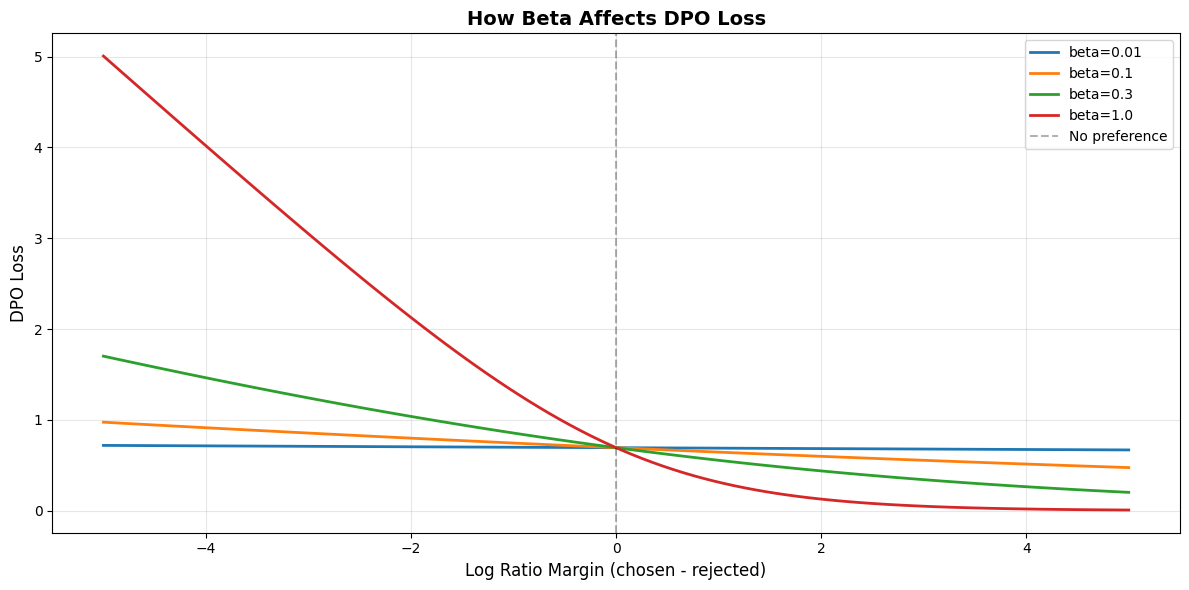

What this plot tells us:

X-axis (margin): How much the model prefers chosen over rejected
  Positive = model prefers chosen (good!)
  Negative = model prefers rejected (bad!)

Y-axis (loss): How much we penalize the model

Notice:
  • Higher beta = steeper curve = stronger penalty for mistakes
  • beta=0.01 is almost flat (gentle corrections)
  • beta=1.0 is very steep (harsh penalties)

Rule of thumb:
  Start with beta=0.1
  If model isn't learning preferences → increase beta
  If model is overfitting to preferences → decrease beta


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the effect of beta on the loss function
margin_range = np.linspace(-5, 5, 100)

plt.figure(figsize=(12, 6))

# Plot DPO loss for different beta values
for beta in [0.01, 0.1, 0.3, 1.0]:
    # The margin is: log(π/π_ref) for chosen - log(π/π_ref) for rejected
    # Positive margin = model prefers chosen (good!)
    # Negative margin = model prefers rejected (bad!)
    
    logits = beta * margin_range
    loss = -np.log(1 / (1 + np.exp(-logits)))  # This is -log(sigmoid(logits))
    plt.plot(margin_range, loss, label=f'beta={beta}', linewidth=2)

plt.xlabel('Log Ratio Margin (chosen - rejected)', fontsize=12)
plt.ylabel('DPO Loss', fontsize=12)
plt.title('How Beta Affects DPO Loss', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.3, label='No preference')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("What this plot tells us:")
print("=" * 60)
print()
print("X-axis (margin): How much the model prefers chosen over rejected")
print("  Positive = model prefers chosen (good!)")
print("  Negative = model prefers rejected (bad!)")
print()
print("Y-axis (loss): How much we penalize the model")
print()
print("Notice:")
print("  • Higher beta = steeper curve = stronger penalty for mistakes")
print("  • beta=0.01 is almost flat (gentle corrections)")
print("  • beta=1.0 is very steep (harsh penalties)")
print()
print("Rule of thumb:")
print("  Start with beta=0.1")
print("  If model isn't learning preferences → increase beta")
print("  If model is overfitting to preferences → decrease beta")

## RLHF: The KL Divergence Leash

If you're doing RLHF (reinforcement learning from human feedback) with PPO, you have a different problem: your policy model might go completely off the rails chasing reward.

Imagine you have a reward model that gives high scores for helpful responses. Without any constraints, your policy might discover that repeating "This is helpful! This is helpful! This is helpful!" 500 times gets a high reward score. Technically the reward model likes it... but it's not actually useful.

(This happens. Like, a lot.)

**The KL divergence constraint** is your safety leash. It penalizes the policy for deviating too far from the reference model (usually the SFT model):

$$\mathcal{L}_{\text{RLHF}} = \mathbb{E}\left[r(x,y) - \lambda_{\text{KL}} \cdot \text{KL}(\pi_\theta || \pi_{\text{ref}})\right]$$

That $\lambda_{\text{KL}}$ (often called `kl_coef`) controls how tight the leash is.

- **Low KL coef (0.01):** Long leash. Policy can wander far from reference. Risky!
- **Medium KL coef (0.1):** Standard leash. Balanced exploration and safety.
- **High KL coef (0.5-2.0):** Short leash. Policy stays close to reference. Safe but limiting.

The goal is to improve on the reference model without going weird. Too loose and you get gibberish. Too tight and you don't improve at all.

In [5]:
class AdaptiveKLController:
    """
    Adaptive KL coefficient for RLHF.
    
    The clever trick: instead of picking a fixed KL coefficient and hoping
    it's right, we can adapt it during training based on what's happening.
    
    The idea:
    - Set a target KL divergence (how much deviation you're comfortable with)
    - If actual KL is too high → increase the coefficient (tighten the leash)
    - If actual KL is too low → decrease the coefficient (loosen the leash)
    
    This way, the KL coefficient automatically adjusts to keep you in the
    sweet spot between "too conservative" and "completely unhinged."
    """
    
    def __init__(self, init_kl_coef=0.1, target_kl=0.01):
        self.kl_coef = init_kl_coef      # Starting coefficient
        self.target_kl = target_kl        # Target KL divergence
        print(f"Initialized adaptive KL controller:")
        print(f"  Starting KL coefficient: {init_kl_coef}")
        print(f"  Target KL divergence: {target_kl}")
    
    def update(self, current_kl):
        """
        Adjust KL coefficient based on current KL divergence.
        
        If KL is too high (> 2x target), we're deviating too much → increase penalty
        If KL is too low (< 0.5x target), we're being too conservative → decrease penalty
        """
        if current_kl > 2 * self.target_kl:
            # Model is diverging too much from reference
            self.kl_coef *= 1.5
            print(f"  KL too high ({current_kl:.4f} > {2*self.target_kl:.4f})")
            print(f"  → Increasing KL coef to {self.kl_coef:.3f} (tightening leash)")
        elif current_kl < 0.5 * self.target_kl:
            # Model is too conservative
            self.kl_coef *= 0.8
            print(f"  KL too low ({current_kl:.4f} < {0.5*self.target_kl:.4f})")
            print(f"  → Decreasing KL coef to {self.kl_coef:.3f} (loosening leash)")
        else:
            print(f"  KL just right ({current_kl:.4f}), keeping coef at {self.kl_coef:.3f}")
        
        return self.kl_coef

# Demo of how this works
print("=" * 60)
print("Adaptive KL Controller Demo")
print("=" * 60)
print()

controller = AdaptiveKLController(init_kl_coef=0.1, target_kl=0.01)
print()

# Simulate some training steps
print("Simulating training:")
print("-" * 60)

# Step 1: KL too high (model diverging)
print("\nStep 1:")
controller.update(current_kl=0.025)

# Step 2: Still too high
print("\nStep 2:")
controller.update(current_kl=0.030)

# Step 3: Now it's better
print("\nStep 3:")
controller.update(current_kl=0.012)

# Step 4: Maybe too low now
print("\nStep 4:")
controller.update(current_kl=0.003)

print()
print("=" * 60)
print()
print("Other important RLHF hyperparameters:")
print()
print("  clip_epsilon (usually 0.2):")
print("    PPO clips policy updates to prevent huge changes.")
print("    Standard value is 0.2, don't mess with it unless you")
print("    know what you're doing.")
print()
print("  ppo_epochs (usually 4):")
print("    How many optimization passes over each batch.")
print("    More epochs = more sample efficient, but risk overfitting.")
print("    4 is a good balance.")

Adaptive KL Controller Demo

Initialized adaptive KL controller:
  Starting KL coefficient: 0.1
  Target KL divergence: 0.01

Simulating training:
------------------------------------------------------------

Step 1:
  KL too high (0.0250 > 0.0200)
  → Increasing KL coef to 0.150 (tightening leash)

Step 2:
  KL too high (0.0300 > 0.0200)
  → Increasing KL coef to 0.225 (tightening leash)

Step 3:
  KL just right (0.0120), keeping coef at 0.225

Step 4:
  KL too low (0.0030 < 0.0050)
  → Decreasing KL coef to 0.180 (loosening leash)


Other important RLHF hyperparameters:

  clip_epsilon (usually 0.2):
    PPO clips policy updates to prevent huge changes.
    Standard value is 0.2, don't mess with it unless you
    know what you're doing.

  ppo_epochs (usually 4):
    How many optimization passes over each batch.
    More epochs = more sample efficient, but risk overfitting.
    4 is a good balance.


## LoRA: Rank and Alpha

When you're using LoRA (Low-Rank Adaptation), you have two key hyperparameters to tune: **rank** (r) and **alpha**.

Quick refresher: LoRA doesn't update the original model weights. Instead, it learns low-rank matrices that get added to the original weights. The rank determines how "expressive" these low-rank matrices can be.

**Rank (r):** The dimensionality of the low-rank decomposition
- Higher rank = more parameters = more capacity = can learn more complex adaptations
- Lower rank = fewer parameters = less capacity = faster and more memory-efficient

**Alpha:** A scaling factor applied to the LoRA updates
- Think of it as the "learning strength" of the LoRA layers
- Standard relationship: `alpha = 2 × rank`

Here's the thing: picking the right rank is a balancing act. Too low and your model can't learn the task (underfitting). Too high and you're wasting memory and computation without much benefit.

The sweet spot depends on your model size and task complexity.

In [ ]:
# LoRA rank selection guide
print("LoRA Rank Selection Guide")
print("=" * 70)
print()
print("Model Size  Task Complexity  Rank   Alpha   % Trainable Params")
print("-" * 70)
print("<1B         Simple           4-8    8-16    ~0.1-0.2%")
print("<1B         Complex          8-16   16-32   ~0.2-0.4%")
print("1B-7B       Simple           8-16   16-32   ~0.2-0.4%")
print("1B-7B       Complex          16-32  32-64   ~0.4-0.8%")
print("7B+         Complex          32-64  64-128  ~0.8-1.6%")
print()
print("Standard relationship: alpha = 2 × rank")
print()
print("-" * 70)
print()

print("What do these ranks actually mean?")
print()
print("  r=4:   MINIMAL capacity")
print("         Good for: Very simple tasks (format changes, style tweaks)")
print("         ~0.1% of full model parameters")
print("         Example: Teaching the model to use a specific format")
print()
print("  r=8:   LOW capacity")
print("         Good for: Simple domain adaptation, basic instructions")
print("         ~0.2% of full model parameters")
print("         Example: Fine-tuning for customer service responses")
print()
print("  r=16:  STANDARD capacity")
print("         Good for: Most tasks, general-purpose fine-tuning")
print("         ~0.4% of full model parameters")
print("         Example: Domain-specific QA, instruction following")
print("         → This is the default you should probably start with")
print()
print("  r=32:  HIGH capacity")
print("         Good for: Complex reasoning, specialized domains")
print("         ~0.8% of full model parameters")
print("         Example: Medical/legal QA, complex code generation")
print()
print("  r=64:  VERY HIGH capacity")
print("         Good for: When r=32 isn't enough (rare)")
print("         ~1.6% of full model parameters")
print("         Example: Highly specialized scientific tasks")
print()

print("=" * 70)
print()
print("Start with r=16, alpha=32")
print()
print("  • Too easy → model converges too fast → try lower rank")
print("  • Too hard → model struggles to learn → try higher rank")
print()
print("Most of the time, r=16 is perfectly fine. Don't overthink it!")

## Hyperparameter Cheat Sheet: Your Quick Reference

Alright, we've covered a lot. Let's consolidate this into some practical, copy-pasteable configurations that actually work.

These are battle-tested starting points. Will they be perfect for your exact use case? Probably not. But they'll get you 90% of the way there, and you can tune from there.

In [7]:
# Quick reference configurations that actually work
print("=" * 70)
print("SFT (Supervised Fine-Tuning) with LoRA")
print("=" * 70)
print("""
SFTConfig(
    learning_rate=3e-4,              # Higher for LoRA (random init)
    batch_size=8,                    # Fits most GPUs
    gradient_accumulation_steps=4,   # → effective batch = 32
    num_epochs=3,                    # 3-5 for most datasets
    warmup_steps=100,                # ~10% of training steps
    lr_scheduler_type="cosine",      # Smooth decay
    max_grad_norm=1.0,               # Gradient clipping
    weight_decay=0.01,               # Standard regularization
)

# LoRA config:
# - rank=16, alpha=32 for most tasks
# - rank=32, alpha=64 for complex tasks
# - rank=8, alpha=16 if memory-constrained
""")

print("=" * 70)
print("DPO (Direct Preference Optimization) with LoRA")
print("=" * 70)
print("""
DPOConfig(
    learning_rate=5e-5,              # MUCH lower than SFT!
    beta=0.1,                        # Standard preference strength
    batch_size=4,                    # Each example = chosen + rejected
    gradient_accumulation_steps=8,   # → effective batch = 32
    num_epochs=1,                    # Usually sufficient for DPO
    warmup_steps=50,                 # Shorter warmup
    lr_scheduler_type="cosine",
    max_grad_norm=1.0,
)

# Beta tuning:
# - Start with 0.1
# - Increase if model isn't learning preferences
# - Decrease if model is overfitting to preferences
""")

print("=" * 70)
print("RLHF (PPO) with LoRA")
print("=" * 70)
print("""
RLHFConfig(
    # Policy network (the language model)
    policy_lr=1e-5,                  # Very low for stability
    
    # Value network (predicts rewards)
    value_lr=5e-5,                   # Can be higher
    
    # KL divergence penalty
    kl_coef=0.1,                     # Keeps policy near reference
    target_kl=0.01,                  # Target KL divergence
    
    # PPO-specific
    clip_epsilon=0.2,                # Standard PPO clipping
    ppo_epochs=4,                    # Optimization passes per batch
    
    # Training
    batch_size=4,                    # Small for RL stability
    gradient_accumulation_steps=8,
    max_grad_norm=0.5,               # Stricter clipping for RL
)

# Use adaptive KL coefficient (see AdaptiveKLController above)
# to automatically adjust kl_coef during training
""")

print("=" * 70)
print()
print("Quick decision guide:")
print()
print("  1. Pick your method (SFT, DPO, or RLHF)")
print("  2. Start with the config above")
print("  3. Adjust batch size to fit your GPU")
print("  4. If you change batch size, scale learning rate (see earlier)")
print("  5. Run a few hundred steps and watch the loss")
print("     • Loss going down smoothly? Great, keep going!")
print("     • Loss exploding (NaN)? Lower learning rate")
print("     • Loss barely moving? Increase learning rate")
print("  6. Tune method-specific params (beta for DPO, kl_coef for RLHF)")
print()
print("That's it. Don't overthink it. These configs work.")

SFT (Supervised Fine-Tuning) with LoRA

SFTConfig(
    learning_rate=3e-4,              # Higher for LoRA (random init)
    batch_size=8,                    # Fits most GPUs
    gradient_accumulation_steps=4,   # → effective batch = 32
    num_epochs=3,                    # 3-5 for most datasets
    warmup_steps=100,                # ~10% of training steps
    lr_scheduler_type="cosine",      # Smooth decay
    max_grad_norm=1.0,               # Gradient clipping
    weight_decay=0.01,               # Standard regularization
)

# LoRA config:
# - rank=16, alpha=32 for most tasks
# - rank=32, alpha=64 for complex tasks
# - rank=8, alpha=16 if memory-constrained

DPO (Direct Preference Optimization) with LoRA

DPOConfig(
    learning_rate=5e-5,              # MUCH lower than SFT!
    beta=0.1,                        # Standard preference strength
    batch_size=4,                    # Each example = chosen + rejected
    gradient_accumulation_steps=8,   # → effective batch = 32
    num_e

## Common Mistakes (And How to Avoid Them)

Let's talk about the mistakes I see people make over and over again. Learn from our collective pain.

### Mistake #1: Using the Same Learning Rate Everywhere

This is the big one. People find a learning rate that works for SFT and then use it for everything.

**Bad:**
```python
# Nooooo!
sft_config = SFTConfig(learning_rate=3e-4)      # ✓ Good for SFT
dpo_config = DPOConfig(learning_rate=3e-4)      # ✗ Way too high!
rlhf_config = RLHFConfig(policy_lr=3e-4)        # ✗ Model will explode!
```

**Good:**
```python
# Yes! Method-specific learning rates
sft_config = SFTConfig(learning_rate=3e-4)      # ✓ Standard for SFT
dpo_config = DPOConfig(learning_rate=5e-5)      # ✓ 5-10x lower
rlhf_config = RLHFConfig(policy_lr=1e-5)        # ✓ Even lower for RL
```

**Why this matters:** DPO and RLHF are much more sensitive than SFT. A learning rate that works fine for supervised learning will send your preference model into the stratosphere.

---

### Mistake #2: Not Scaling Learning Rate for LoRA

LoRA uses randomly initialized matrices. They need a higher learning rate than pre-trained weights.

**Bad:**
```python
# Using full fine-tuning LR with LoRA
config = SFTConfig(learning_rate=3e-5)  # ✗ Too low! LoRA will barely learn
```

**Good:**
```python
# Higher LR for LoRA's random initialization
config = SFTConfig(learning_rate=3e-4)  # ✓ About 10x higher than full FT
```

**Why this matters:** With a too-low learning rate, LoRA will technically train, but it'll take forever and might not reach good performance. You'll waste hours wondering why your model isn't learning.

---

### Mistake #3: Skipping Warmup

Starting training with a high learning rate is like flooring the accelerator when your car is still in the driveway. Recipe for chaos.

**Bad:**
```python
config = SFTConfig(
    learning_rate=3e-4,
    warmup_steps=0,  # ✗ No warmup = unstable start
)
```

**Good:**
```python
config = SFTConfig(
    learning_rate=3e-4,
    warmup_steps=100,  # ✓ 5-10% of training steps
)
```

**Why this matters:** At the start of training, gradients can be large and unpredictable. Warmup gives the model a chance to stabilize before taking big steps. It's especially important for LoRA, where those random matrices start with crazy gradients.

---

### Mistake #4: Ignoring Effective Batch Size

"My batch size is 4" is not complete information. The *effective* batch size is what matters.

**Misleading:**
```python
# These look the same, but they're not!
config_a = SFTConfig(batch_size=32, gradient_accumulation_steps=1)
config_b = SFTConfig(batch_size=4, gradient_accumulation_steps=8)
```

Both have effective batch size = 32, but:
- Config A: Process 32 examples at once (high memory, one update)
- Config B: Process 4 examples at a time, 8 accumulation steps (low memory, one update)

**Why this matters:** If you report "I used batch size 4" without mentioning gradient accumulation, others can't reproduce your results. Always think in terms of effective batch size.

---

### Mistake #5: Cranking Up Beta Without Good Data

High beta with noisy preference data is a disaster waiting to happen.

**Bad:**
```python
# AI-generated preference labels (might be noisy)
dpo_config = DPOConfig(
    beta=1.0,  # ✗ Too aggressive for noisy data
)
```

**Good:**
```python
# AI-generated preference labels (might be noisy)
dpo_config = DPOConfig(
    beta=0.05,  # ✓ Gentle, won't overfit to noise
)
```

**Why this matters:** Beta amplifies your preference signal. If that signal is noisy, high beta means "strongly overfit to garbage." Start low, increase if needed.

---

The pattern here? Most mistakes come from copy-pasting configs without understanding what the hyperparameters actually do. Now you know better.

## Summary: Your Hyperparameter Tuning Workflow

Let's bring this all together into a practical workflow.

**Step 1: Pick Your Starting Point**

| Method | Learning Rate | Batch Size (effective) | Key Parameter |
|--------|--------------|----------------------|---------------|
| SFT (LoRA) | 3e-4 | 32-128 | rank=16 |
| DPO (LoRA) | 5e-5 | 16-64 | beta=0.1 |
| RLHF (LoRA) | 1e-5 | 16-64 | kl_coef=0.1 |

**Step 2: Adjust for Your Hardware**
- Fit batch size to your GPU memory
- Use gradient accumulation to reach target effective batch
- Scale learning rate if you significantly change batch size (use sqrt scaling)

**Step 3: Set Warmup and Schedule**
- Warmup steps = 5-10% of total training steps
- Use cosine decay (it just works)
- For short runs (<1000 steps), constant LR is fine

**Step 4: Start Training and Watch Closely**
- Check loss after 50-100 steps
- Loss smoothly decreasing? You're good!
- Loss stuck? Increase learning rate
- Loss exploding? Decrease learning rate
- Weird oscillations? Reduce batch size or increase warmup

**Step 5: Tune Method-Specific Parameters**
- DPO: Adjust beta based on model behavior and data quality
- RLHF: Use adaptive KL controller, watch for model collapse
- LoRA: If model struggles, try higher rank

**Tuning Priority:**
1. **Learning rate** ← Start here! Biggest impact
2. **Batch size** ← For stability and speed
3. **Method-specific** ← Beta for DPO, KL for RLHF
4. **Secondary** ← Warmup, weight decay, clipping

Remember: these hyperparameters aren't magic incantations. They're knobs that control how your model learns. Understanding what each knob does means you can tune intelligently instead of randomly.

## What's Next?

Now you know how to tune hyperparameters without setting everything on fire. Nice!

But hyperparameters only matter if you can measure whether they're working. And "loss going down" is just the start—there are much better ways to evaluate whether your model is actually getting better at the thing you care about.

That's what we'll cover next: comprehensive evaluation metrics that go beyond loss.